# Comparing models

We will make some changes to the model to forecast `vwap` values

In [1]:
import sklearn.preprocessing as sk

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import sampler
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import *
from model import RNN

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
print(torch.cuda.is_available())

False


## Preview

In [2]:
training_set = pd.read_csv('../data/gemini_BTCUSD_1hr.csv')
print(len(training_set))
training_set.head()

55137


,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1642809600000,2022-01-22 00:00:00,BTCUSD,36465.97,36817.87,36412.54,36428.03,9.394712
1,1642806000000,2022-01-21 23:00:00,BTCUSD,36155.72,36841.97,35825.24,36465.97,165.870507
2,1642802400000,2022-01-21 22:00:00,BTCUSD,36701.37,37150.99,35389.69,36155.72,254.590973
3,1642798800000,2022-01-21 21:00:00,BTCUSD,38340.16,38452.32,36165.33,36701.37,433.812937
4,1642795200000,2022-01-21 20:00:00,BTCUSD,37981.08,38454.00,37578.67,38340.16,247.358995


## Pre-processing the data

In [3]:
# Extracting columns and reverse
training_set = training_set[['Open', 'High', 'Low', 'Close','Volume']][::-1]

# Appropriate scaling to avoid large values
x_scaler = sk.MinMaxScaler(feature_range = (0, 1))
y_scaler = sk.MinMaxScaler(feature_range = (0, 1))
# Transforming into standardized data
x_data = x_scaler.fit_transform(vwap(training_set).reshape(-1,1)).flatten()
y_data = y_scaler.fit_transform(vwap(training_set).reshape(-1,1)).flatten()

training_set.head()

,Open,High,Low,Close,Volume
55136,0.00,245.00,0.00,245.00,0.606654
55135,245.00,245.00,244.50,245.00,4.453649
55134,245.00,245.00,244.92,244.92,3.016926
55133,244.92,244.92,244.25,244.25,3.895252
55132,244.25,244.99,244.02,244.99,3.920632


Creating own dataset

In [16]:
class MyDset(Dataset):

    def __init__(self, data, target, window, future=0):
        self.cnter = 0

        x_vals = []
        y_vals = []
        start = 0 + window 
        end = len(data) - future

        for i in range(start, end):
            x = data[(i-window):i]
            y = target[i:(i+future)]

            x_vals.append(x)
            y_vals.append(y)
        
        tensor_x = torch.Tensor(np.array(x_vals))[:,:,np.newaxis]
        tensor_y = torch.Tensor(np.array(y_vals))[:,:,np.newaxis]
        
        self.data = tensor_x
        self.target = tensor_y
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

In [17]:
testing = torch.zeros([100,2])

testing = testing[:,:,np.newaxis]
testing.shape

torch.Size([100, 2, 1])

In [18]:
future = 1
set_train = MyDset(x_data, y_data, window=4, future = future)
batch_size = 100
train_split = int(0.8*(len(set_train)))

loader_train = DataLoader(set_train, batch_size = batch_size,\
   sampler=sampler.SubsetRandomSampler(range(train_split)))
   
loader_test = DataLoader(set_train, batch_size = batch_size,\
   sampler=sampler.SubsetRandomSampler(range(train_split, len(set_train))))

for x in loader_train:
   print(x[0].shape)
   break

torch.Size([100, 4, 1])


In [20]:
input_size = 1
hidden_size = 100
num_layer = 1
num_class = future
model = RNN(input_size, hidden_size, num_layer, num_class)

model(torch.zeros([100,4,1]))

C:\Users\yunjie wang\anaconda3\lib\site-packages\torch\nn\functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor([[0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0.5052],
        [0

Testing implementation

In [21]:
input_size = 1
hidden_size = 10
num_layer = 1
num_class = future
model = RNN(input_size, hidden_size, num_layer, num_class)


learning_rate = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 20

In [22]:
print_every = 100
for e in range(epochs):

    for t, (x,y) in enumerate(loader_train):

        model.train()  # put model to training mode

        x = x.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.float32)

        scores = model(x)
        
        loss = criterion(scores, y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if t % print_every == 0:
            print('Epoch %d Iteration %d, loss = %.8f' % (e, t, loss.item()))
            print(t)

    torch.save(model.state_dict(), 'LSTMvwap.ckpt')


C:\Users\yunjie wang\anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([100, 1, 1])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\yunjie wang\anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([33, 1, 1])) that is different to the input size (torch.Size([33, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Iteration 0, loss = 0.10598630
0
Epoch 1 Iteration 0, loss = 0.00349453
0
Epoch 2 Iteration 0, loss = 0.00336928
0
Epoch 3 Iteration 0, loss = 0.00285206
0
Epoch 4 Iteration 0, loss = 0.00385463
0
Epoch 5 Iteration 0, loss = 0.00311278
0
Epoch 6 Iteration 0, loss = 0.00308830
0
Epoch 7 Iteration 0, loss = 0.00331527
0
Epoch 8 Iteration 0, loss = 0.00360579
0
Epoch 9 Iteration 0, loss = 0.00379406
0
Epoch 10 Iteration 0, loss = 0.00320523
0
Epoch 11 Iteration 0, loss = 0.00342738
0
Epoch 12 Iteration 0, loss = 0.00348733
0
Epoch 13 Iteration 0, loss = 0.00376036
0
Epoch 14 Iteration 0, loss = 0.00363602
0
Epoch 15 Iteration 0, loss = 0.00428261
0
Epoch 16 Iteration 0, loss = 0.00316784
0
Epoch 17 Iteration 0, loss = 0.00386060
0
Epoch 18 Iteration 0, loss = 0.00289364
0
Epoch 19 Iteration 0, loss = 0.00271106
0


# Testing

In [23]:
test = []
test_x = None
test_y = None
for (x,y) in loader_test:
    test.append((x,y))
print(len(test))

test_x, test_y = test[0]
print(test_x)

5
tensor([[[0.4816],
         [0.4635],
         [0.4910],
         [0.5098]],

        [[0.5358],
         [0.5168],
         [0.5249],
         [0.5354]],

        [[0.3788],
         [0.3987],
         [0.3979],
         [0.3948]],

        [[0.5877],
         [0.6179],
         [0.6464],
         [0.6545]],

        [[0.5802],
         [0.5764],
         [0.5358],
         [0.5168]],

        [[0.8868],
         [0.8653],
         [0.8423],
         [0.8709]],

        [[0.6988],
         [0.7216],
         [0.7058],
         [0.7257]],

        [[0.1882],
         [0.1907],
         [0.1913],
         [0.1903]],

        [[0.4826],
         [0.4799],
         [0.4694],
         [0.4695]],

        [[0.8127],
         [0.7943],
         [0.8287],
         [0.8570]],

        [[0.5039],
         [0.5076],
         [0.4845],
         [0.4930]],

        [[0.9143],
         [0.9349],
         [0.9741],
         [0.9466]],

        [[0.4998],
         [0.5040],
         [0.4816],
     

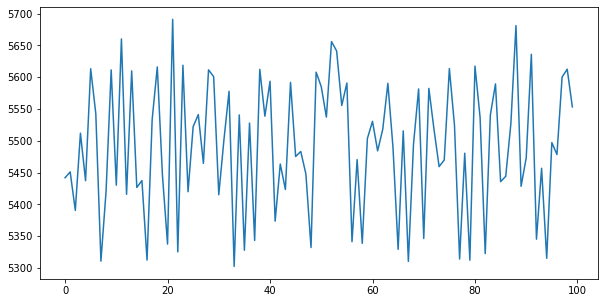

In [24]:
model.eval()

predicted = model(test_x).data.numpy()
predicted = y_scaler.inverse_transform(predicted)


plt.figure(figsize=(10,5))
plt.plot(predicted)

In [25]:
test_y = sk.MinMaxScaler.inverse_transform(test_y)

plt.figure(figsize=(10,5))
plt.plot(test_y)

TypeError: inverse_transform() missing 1 required positional argument: 'X'

ValueError: x and y can be no greater than 2D, but have shapes (100,) and torch.Size([100, 1, 1])

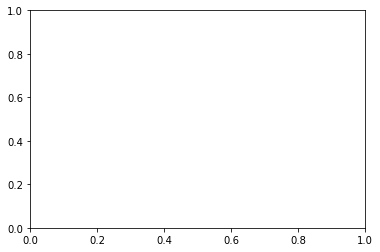

In [26]:
plt.plot(test_y, label="real")
plt.plot(predicted, label="predicted")
plt.legend()